In [1]:
###--------------------------------------------LOAD LIBRARIES

import numpy as np
import pandas as pd
import scanpy as sc
import tspex
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
sns.set(style = "whitegrid", font_scale=1.5)

In [2]:
###--------------------------------------------LOAD DATA

adata = sc.read_h5ad("../../../processed-data/gene-risk-LR-analysis/04-specificity_LR_targets/sce.h5ad")
adata = adata[adata.obs['cellType_broad_hc']!='drop']
adata.X = adata.X.astype(float)
adata.layers['logcounts'] = adata.layers['logcounts'].astype(float)
adata.obsm['tsne'] = adata.obsm['TSNE'].astype(float)


/camp/lab/gandhis/home/users/grantpm/.conda/envs/panpipes/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/slurm_48841202/ipykernel_59978/2489134637.py:6: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.layers['logcounts'] = adata.layers['logcounts'].astype(float)


###------------------------------------------------------------------- FYN  -  EFNA5 -------------------------------------------------------------------###
Total number of nuclei  56447
% of nuclei expressing ligand  FYN : 56.05966658989849
% of nuclei expressing receptor  EFNA5 : 51.50317997413503
% of nuclei expressing both ligand and receptor:  41.93136924903006


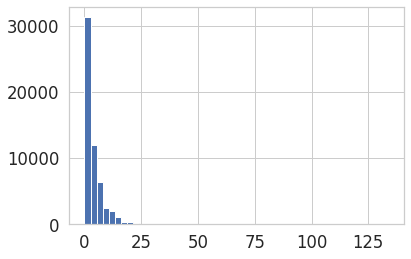

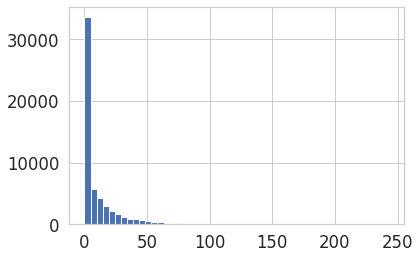

% of co-expressing nuclei per layer:
Excit_L5/6      87.253719
Excit_L5        85.788423
Excit_L6        79.631696
Excit_L3        69.920643
Inhib           65.898618
Excit_L4        42.043551
Excit_L2/3      35.365854
Astro           30.007540
Excit_L3/4/5    10.581663
EndoMural        5.006954
Oligo            2.404994
OPC              2.268041
Micro            1.686446
Name: cellType_layer, dtype: float64
###------------------------------------------------------------------- EFNA5  -  EPHA5 -------------------------------------------------------------------###
Total number of nuclei  56447
% of nuclei expressing ligand  EFNA5 : 51.50317997413503
% of nuclei expressing receptor  EPHA5 : 32.322355483905255
% of nuclei expressing both ligand and receptor:  28.36288908179354


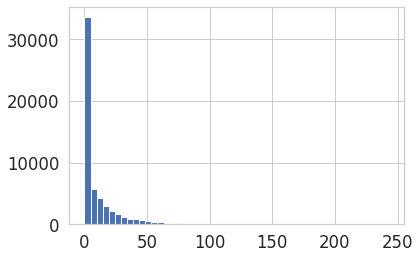

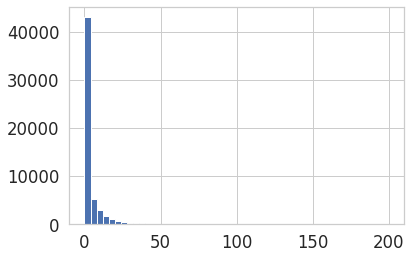

% of co-expressing nuclei per layer:
Excit_L5        90.339321
Excit_L5/6      89.384801
Excit_L6        85.546875
Excit_L3        62.214361
Excit_L2/3      41.463415
Excit_L4        32.328308
Inhib           17.258516
Excit_L3/4/5     9.595794
OPC              0.927835
Oligo            0.826143
Astro            0.628299
EndoMural        0.463607
Micro            0.124922
Name: cellType_layer, dtype: float64
###------------------------------------------------------------------- FYN  -  EPHA5 -------------------------------------------------------------------###
Total number of nuclei  56447
% of nuclei expressing ligand  FYN : 56.05966658989849
% of nuclei expressing receptor  EPHA5 : 32.322355483905255
% of nuclei expressing both ligand and receptor:  26.986376601059405


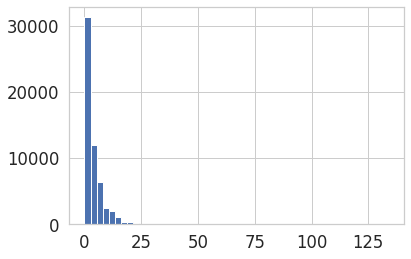

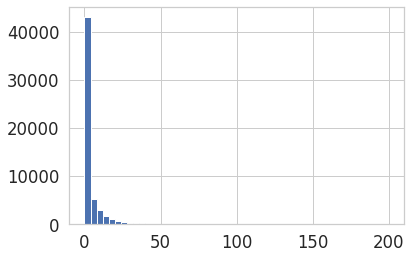

% of co-expressing nuclei per layer:
Excit_L5/6      83.675111
Excit_L5        82.554890
Excit_L6        74.386161
Excit_L3        57.185199
Excit_L4        26.005025
Excit_L2/3      23.170732
Inhib           19.246408
Excit_L3/4/5    10.318764
OPC              9.381443
EndoMural        1.112656
Oligo            0.835322
Astro            0.728826
Micro            0.062461
Name: cellType_layer, dtype: float64


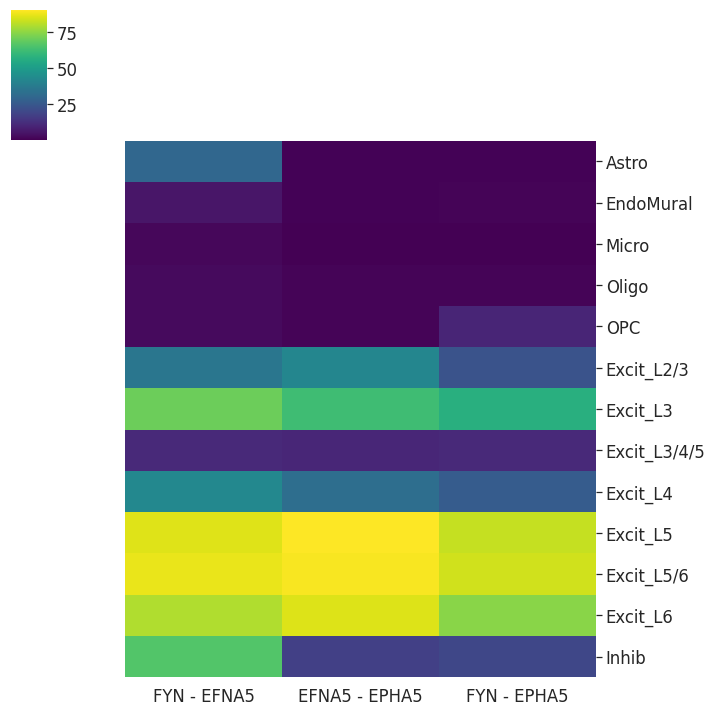

In [3]:
###--------------------------------------------RUN ANALYSIS
phos = pd.DataFrame(
    {'genesymbol_intercell_source': ['FYN', 'EFNA5', 'FYN'],
     'genesymbol_intercell_target': ['EFNA5', 'EPHA5', 'EPHA5']
    })

for n in range(0, np.shape(phos)[0]):
    print('###-------------------------------------------------------------------', phos.iloc[n,0], ' - ', phos.iloc[n,1], '-------------------------------------------------------------------###')
    df1 = adata[:, adata.var['gene_name'].str.contains(phos.iloc[n,0])].to_df().rename(columns={phos.iloc[n,0] : "Ligand"})
    df2 = adata[:, adata.var['gene_name'].str.contains(phos.iloc[n,1])].to_df().rename(columns={phos.iloc[n,1] : "Receptor"})
    df = df1.merge(df2, left_index = True, right_index = True, how = 'left')
    df['LR'] = (df['Ligand']>1) * (df['Receptor']>1)
    
    print('Total number of nuclei ', np.shape(df)[0])
    
    print('% of nuclei expressing ligand ', phos.iloc[n,0], ':', (df['Ligand']>1).sum()/np.shape(df)[0]*100)
    
    print('% of nuclei expressing receptor ', phos.iloc[n,1], ':', (df['Receptor']>1).sum()/np.shape(df)[0]*100)
    
    print('% of nuclei expressing both ligand and receptor: ', (df['LR']==True).sum()/np.shape(df)[0]*100)

    df['Ligand'].hist(bins = 50)
    plt.show()
    
    df['Receptor'].hist(bins = 50)
    plt.show()
    df = df.merge(adata.obs['cellType_layer'], left_index = True, right_index = True, how = 'left')
    print("% of co-expressing nuclei per layer:")
    print(100*(df[df['LR']==True]['cellType_layer'].value_counts(sort=False)/df['cellType_layer'].value_counts(sort=False)).sort_values(ascending=False))
    if (n==0):
        summary = 100*(df[df['LR']==True]['cellType_layer'].value_counts(sort=False)/df['cellType_layer'].value_counts(sort=False))
        summary = summary.to_frame().rename(columns={'cellType_layer' : phos.iloc[n,0]+' - '+phos.iloc[n,1]})
    else:
        summary = summary.merge(100*(df[df['LR']==True]['cellType_layer'].value_counts(sort=False)/df['cellType_layer'].value_counts(sort=False)).to_frame().rename(columns={'cellType_layer' : phos.iloc[n,0]+' - '+phos.iloc[n,1]}), left_index = True, right_index = True, how = 'left')
        
sns.clustermap(summary, cmap = 'viridis', row_cluster = False, col_cluster = False)
plt.savefig('../../../plots/gene-risk-LR-analysis/05-intracellular_coexpression/smalltgtlist_snRNAseq_coexpression_heatmap.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()


In [4]:
import scanpy as sc
adata.var_names_make_unique(join='.')

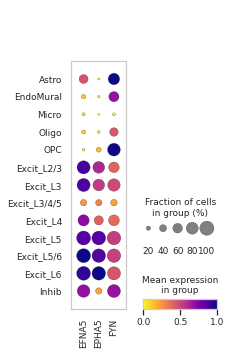

In [5]:
markers = ['EFNA5', 'EPHA5', 'FYN']

sns.set(style = "whitegrid", font_scale=0.9)
fig = sc.pl.dotplot(adata, markers, groupby=['cellType_layer'], standard_scale='var', cmap = 'plasma_r', layer = 'logcounts', show = False)
plt.savefig('../../../plots/gene-risk-LR-analysis/05-intracellular_coexpression/dotplot_FYN-EFNA5-EPHA5_expression.pdf', bbox_inches = 'tight')
plt.show()